In [ ]:
# 顧客區隔的購買產品分析

In [ ]:
## 載入套件與讀取資料

In [ ]:
### 載入套件

In [1]:
# 載入所需套件

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
# 從sklearn套件中，載入KMeans方法
from sklearn.preprocessing import StandardScaler
# 從sklearn套件中，載入KMeans方法
from sklearn.cluster import KMeans

In [2]:
'''
圖形中有中文字型的問題
參考
https://codertw.com/%E7%A8%8B%E5%BC%8F%E8%AA%9E%E8%A8%80/359974/
'''
from matplotlib.font_manager import FontProperties

han_font = FontProperties(fname=r"c:/windows/fonts/msjh.ttc", size=14) # 中文字形

In [3]:
'''
設計圖形呈現的外觀風格
'''
sns.set(style="whitegrid")

In [ ]:
### 讀取資料

In [4]:
# 讀入資料檔
df = pd.read_excel('Online Retail.xlsx')

In [ ]:
### 資料清理

In [5]:
# 去除CustomerID沒有資料的紀錄
df = df.dropna(subset=['CustomerID'])

In [6]:
from datetime import date

df = df.assign(PurchaseDate=df.InvoiceDate.apply(lambda x: x.date()))

# 取出2010-12-09到2011-12-09一年之間的資料
df = df[df.PurchaseDate>=date(2010, 12, 9)]

In [7]:
#取出購買紀錄(不包含取消紀錄)
df = df[df.Quantity>0] 

In [ ]:
### 資料彙整

In [8]:
# 計算發票上物品總價(單價*數量)
df = df.assign(Total=df.UnitPrice*df.Quantity)

In [ ]:
## 利用RFM Model進行顧客區隔

In [ ]:
### 計算每位顧客的Recency、Frequency和Monetary

In [9]:
# 將計算# Recency的方式寫為函數
def recency(pdate):
    # 計算最近購買日期與2011-12-10的差(pdate.max()是最近的購買日期)
    dt = date(2011,12,10) - pdate.max()
    # dt.days：轉換為以天計算的方式
    return(dt.days)

In [10]:
# 將計算Frequency的方式寫為函數
def frequency(inv):
    return(np.log(inv.nunique()))

In [11]:
#將計算Monetary的方式寫為函數
def monetary(tot):
    return(np.log10(tot.sum()+1))

In [12]:
# 計算每位顧客的Recency、Frequency和Monetary
CustomerData = df.groupby(["CustomerID"]).agg({"PurchaseDate": recency,
                                               "InvoiceNo": frequency,
                                               "Total": monetary}).reset_index()\
.rename(columns={"PurchaseDate": "Recency",
                 "InvoiceNo": "Frequency",
                 "Total": "Monetary"})

In [ ]:
### 將Recency、Frequency和Monetary標準化

In [13]:
# 標準化函數
scaler = StandardScaler()

In [14]:
# 將特徵值進行標準化
X = scaler.fit_transform(CustomerData.iloc[:, 1:].values)

In [ ]:
### 進行K-means集群分析

In [15]:
# 預設K-means集群演算法參數，將顧客分為5群
km = KMeans(
    n_clusters=5, init='random',
    n_init=10, max_iter=300,
    tol=1e-04, random_state=0
)

In [16]:
# K-means集群的結果
CustomerData = CustomerData.assign(ClusterID=km.fit_predict(X))

<Figure size 720x360 with 0 Axes>

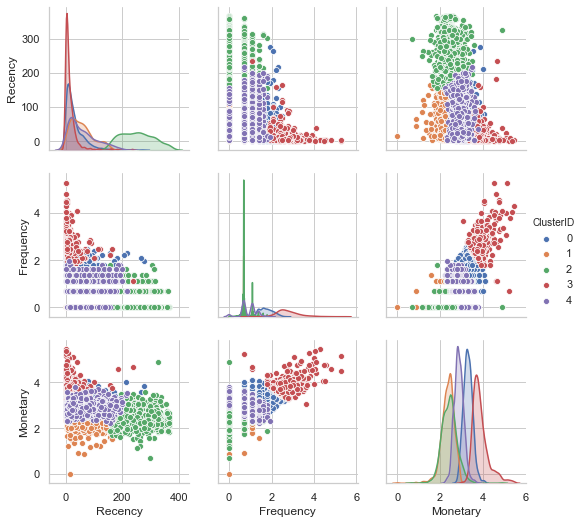

In [17]:
plt.figure(figsize=[10, 5]) #圖的大小
ax = sns.pairplot(CustomerData, vars=["Recency", "Frequency", "Monetary"], hue="ClusterID")

In [18]:
# 計算各集群的顧客人數
ClusterSize = CustomerData.groupby("ClusterID")["CustomerID"].count().reset_index()

Text(0.5, 1.0, '各集群的顧客人數')

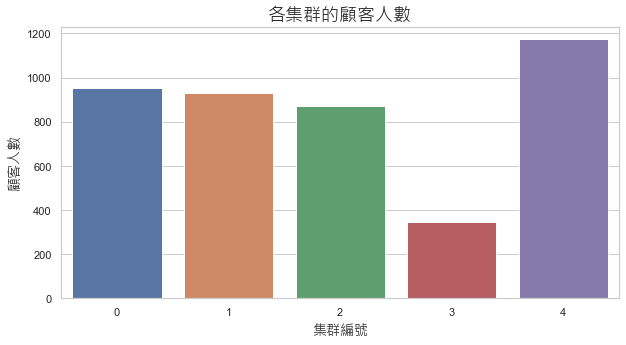

In [19]:
# 以長條圖呈現各集群的顧客人數
plt.figure(figsize=[10, 5])
ax = sns.barplot(x="ClusterID", y="CustomerID", data=ClusterSize)
ax.set_xlabel("集群編號", fontproperties=han_font)
ax.set_ylabel("顧客人數", fontproperties=han_font)
ax.set_title('各集群的顧客人數', fontproperties=han_font, fontsize=18)

In [28]:
# 計算各集群的顧客人數佔全體比例
Percent=np.around(ClusterSize.CustomerID/ClusterSize.CustomerID.sum()*100, 2)

In [23]:
# 將顧客區隔分析的結果與原先的資料合併
df = df.merge(CustomerData[["CustomerID", "ClusterID"]], how="left", on="CustomerID")

In [ ]:
## 統計銷售總數最多的前十項商品

In [24]:
MajorProducts = df.groupby("Description")["Quantity"].sum().reset_index().sort_values("Quantity", ascending=False).iloc[0:10, ]

Text(0.5, 1.0, '銷售總數最多的前10項商品')

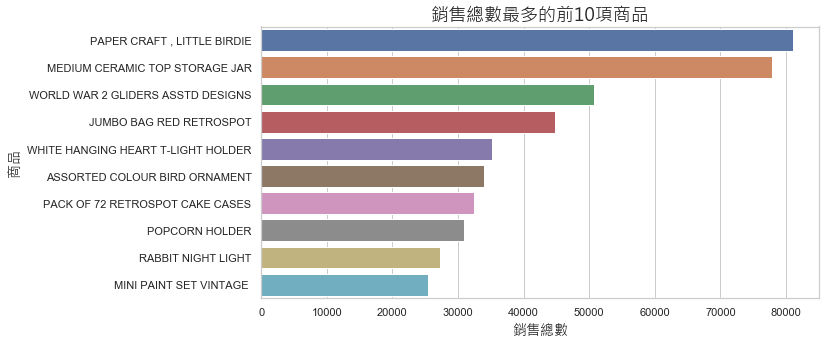

In [25]:
# 以長條圖呈現各項商品的銷售總數
plt.figure(figsize=[10, 5])
ax = sns.barplot(x="Quantity", y="Description", data=MajorProducts)
ax.set_xlabel("銷售總數", fontproperties=han_font)
ax.set_ylabel("商品", fontproperties=han_font)
ax.set_title('銷售總數最多的前10項商品', fontproperties=han_font, fontsize=18)

In [40]:
df = df.loc[df.Description.isin(MajorProducts.Description.values), ]

In [51]:
df.groupby(["Description", "ClusterID"]).Quantity.sum()

Description                         ClusterID
ASSORTED COLOUR BIRD ORNAMENT       0             8996
                                    1              826
                                    2             1002
                                    3            18139
                                    4             5051
JUMBO BAG RED RETROSPOT             0             7645
                                    1              647
                                    2              641
                                    3            31362
                                    4             4527
MEDIUM CERAMIC TOP STORAGE JAR      0              638
                                    1              203
                                    2            74262
                                    3             2343
                                    4              470
MINI PAINT SET VINTAGE              0             5184
                                    1              504
                   